In [10]:
"""
NASDAQ-100 Predictive Analytics Notebook
=====================================
Autor     : Angel Samuel Rodriguez Perez
Versión   : 2.0.0
Fecha     : 2025-07-26
Propósito : Pipeline profesional para predicción de precios del NASDAQ-100
           usando técnicas avanzadas de machine learning y feature engineering.

Requisitos:
- kagglehub
- pandas>=1.5.0
- scikit-learn>=1.1.0
- xgboost>=1.6.0
- shap>=0.41.0
"""

# Configuración global
import warnings
import logging
import sys
from pathlib import Path
import os

# Suprimir warnings para output limpio
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Configurar logging profesional
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

# Constantes del proyecto
RANDOM_STATE = 42
SPLIT_DATE = "2023-01-01"

print("=" * 60)
print("    NASDAQ-100 PREDICTIVE ANALYTICS PIPELINE")
print("=" * 60)


    NASDAQ-100 PREDICTIVE ANALYTICS PIPELINE


In [28]:
# --- Librerías core ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import logging
# --- Librerías de machine learning ---
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import xgboost as xgb

# --- Interpretabilidad ---
import shap

# --- Configuración de visualización ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

logging.info("✅ Todas las librerías importadas correctamente")

In [12]:
def setup_kaggle_data() -> str:
    """
    Descarga y configura la ruta del dataset NASDAQ-100 desde Kaggle.

    Returns:
        str: Ruta al directorio del dataset
    """
    try:
        import kagglehub
        path_to_dataset = kagglehub.dataset_download(
            "novandraanugrah/nasdaq-100-nas100-historical-price-data"
        )
        logging.info(f"Dataset descargado exitosamente: {path_to_dataset}")
        return path_to_dataset
    except ImportError:
        logging.warning("KaggleHub no instalado. Usando ruta predeterminada.")
        return "/root/.cache/kagglehub/datasets/novandraanugrah/nasdaq-100-nas100-historical-price-data/versions/1"
    except Exception as e:
        logging.error(f"Error en descarga: {e}")
        return "/root/.cache/kagglehub/datasets/novandraanugrah/nasdaq-100-nas100-historical-price-data/versions/1"

def load_and_clean_data(file_path: str) -> pd.DataFrame:
    """
    Carga y limpia los datos diarios del NASDAQ-100.

    Args:
        file_path (str): Ruta al archivo CSV

    Returns:
        pd.DataFrame: DataFrame limpio con índice datetime
    """
    try:
        # Leer archivo con formato especial
        with open(file_path, 'r') as f:
            lines = f.readlines()

        # Procesar header
        header_raw = lines[0].strip().replace('\t\t', '\t').strip('\t')

        # Procesar datos
        data_rows = []
        for line in lines[1:]:
            if line.strip():
                parts = line.strip().split()
                if len(parts) >= 7:
                    full_datetime = f"{parts[0]} {parts[1]}"
                    numeric_parts = [full_datetime] + parts[2:7]
                    data_rows.append(numeric_parts)

        # Crear DataFrame
        columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
        df = pd.DataFrame(data_rows, columns=columns)

        # Procesar fechas y tipos
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
        df.set_index('DateTime', inplace=True)
        df.sort_index(inplace=True)

        # Convertir a numérico
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Limpiar datos
        df = df.dropna(subset=numeric_cols)
        df = df[~df.index.duplicated(keep='first')]

        logging.info(f"✅ Datos cargados: {len(df):,} filas desde {df.index.min().date()} hasta {df.index.max().date()}")
        return df

    except Exception as e:
        logging.error(f"❌ Error cargando datos: {e}")
        raise

def evaluate_model(y_true, y_pred, model_name: str, dataset: str = "Test"):
    """
    Evalúa un modelo con métricas estándar.

    Args:
        y_true: Valores reales
        y_pred: Predicciones
        model_name (str): Nombre del modelo
        dataset (str): Nombre del conjunto de datos

    Returns:
        dict: Diccionario con métricas
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics = {
        'Model': model_name,
        'Dataset': dataset,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

    print(f"\n{model_name} - {dataset} Performance:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.4f}")

    return metrics

logging.info("✅ Funciones auxiliares definidas")


In [19]:
dataset_dir = "/kaggle/input/nasdaq-100-nas100-historical-price-data"
print("Archivos en el dataset:")
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        print(os.path.join(root, file))


Archivos en el dataset:
/kaggle/input/nasdaq-100-nas100-historical-price-data/1h_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/1d_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/4h_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/30m_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/1Month_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/5m_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/1m_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/15m_data.csv
/kaggle/input/nasdaq-100-nas100-historical-price-data/1w_data.csv


In [22]:
# Ruta al archivo CSV correcto de datos diarios
full_file_path = "/kaggle/input/nasdaq-100-nas100-historical-price-data/1d_data.csv"

def load_daily_data(path_to_file):
    # Leer archivo CSV con separador por tabulador (según formato de Kaggle)
    df = pd.read_csv(path_to_file, delimiter='\t')

    # Reparar header si es necesario (split columnas compuestas, etc.)
    if '\t' in df.columns[0]:
        new_cols = df.columns[0].split('\t') + list(df.columns[1:])
        df.columns = new_cols

    # Convertir y preparar fecha
    df['Date'] = pd.to_datetime(df['DateTime'], errors='coerce').dt.normalize()
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    if 'DateTime' in df.columns:
        df = df.drop(columns=['DateTime'])

    # Asegurar tipos numéricos
    num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

    # Eliminar filas con NAs en columnas numéricas
    df = df.dropna(subset=num_cols)

    print(f"✅ Archivo procesado: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"   Rango temporal: {df.index.min().date()} — {df.index.max().date()}")

    return df

# Cargar dataframe usando la ruta correcta
df_raw = load_daily_data(full_file_path)

print(f"Datos cargados: {df_raw.shape[0]:,} filas, {df_raw.shape[1]} columnas")
print(df_raw.head())


✅ Archivo procesado: 2,227 filas × 6 columnas
   Rango temporal: 2016-11-15 — 2025-07-15
Datos cargados: 2,227 filas, 6 columnas
              Open    High     Low   Close  Volume  TickVolume
Date                                                          
2016-11-15  4699.6  4781.0  4697.0  4767.5       0       73309
2016-11-16  4765.7  4796.5  4738.2  4785.9       0       55611
2016-11-17  4778.8  4832.9  4778.8  4831.7       0       49542
2016-11-18  4830.2  4842.2  4804.9  4812.4       0       38935
2016-11-21  4806.4  4864.0  4805.5  4858.8       0       36713



ANÁLISIS EXPLORATORIO DE DATOS


/tmp/ipython-input-24-1598808123.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,1].boxplot(yearly_data, labels=years)


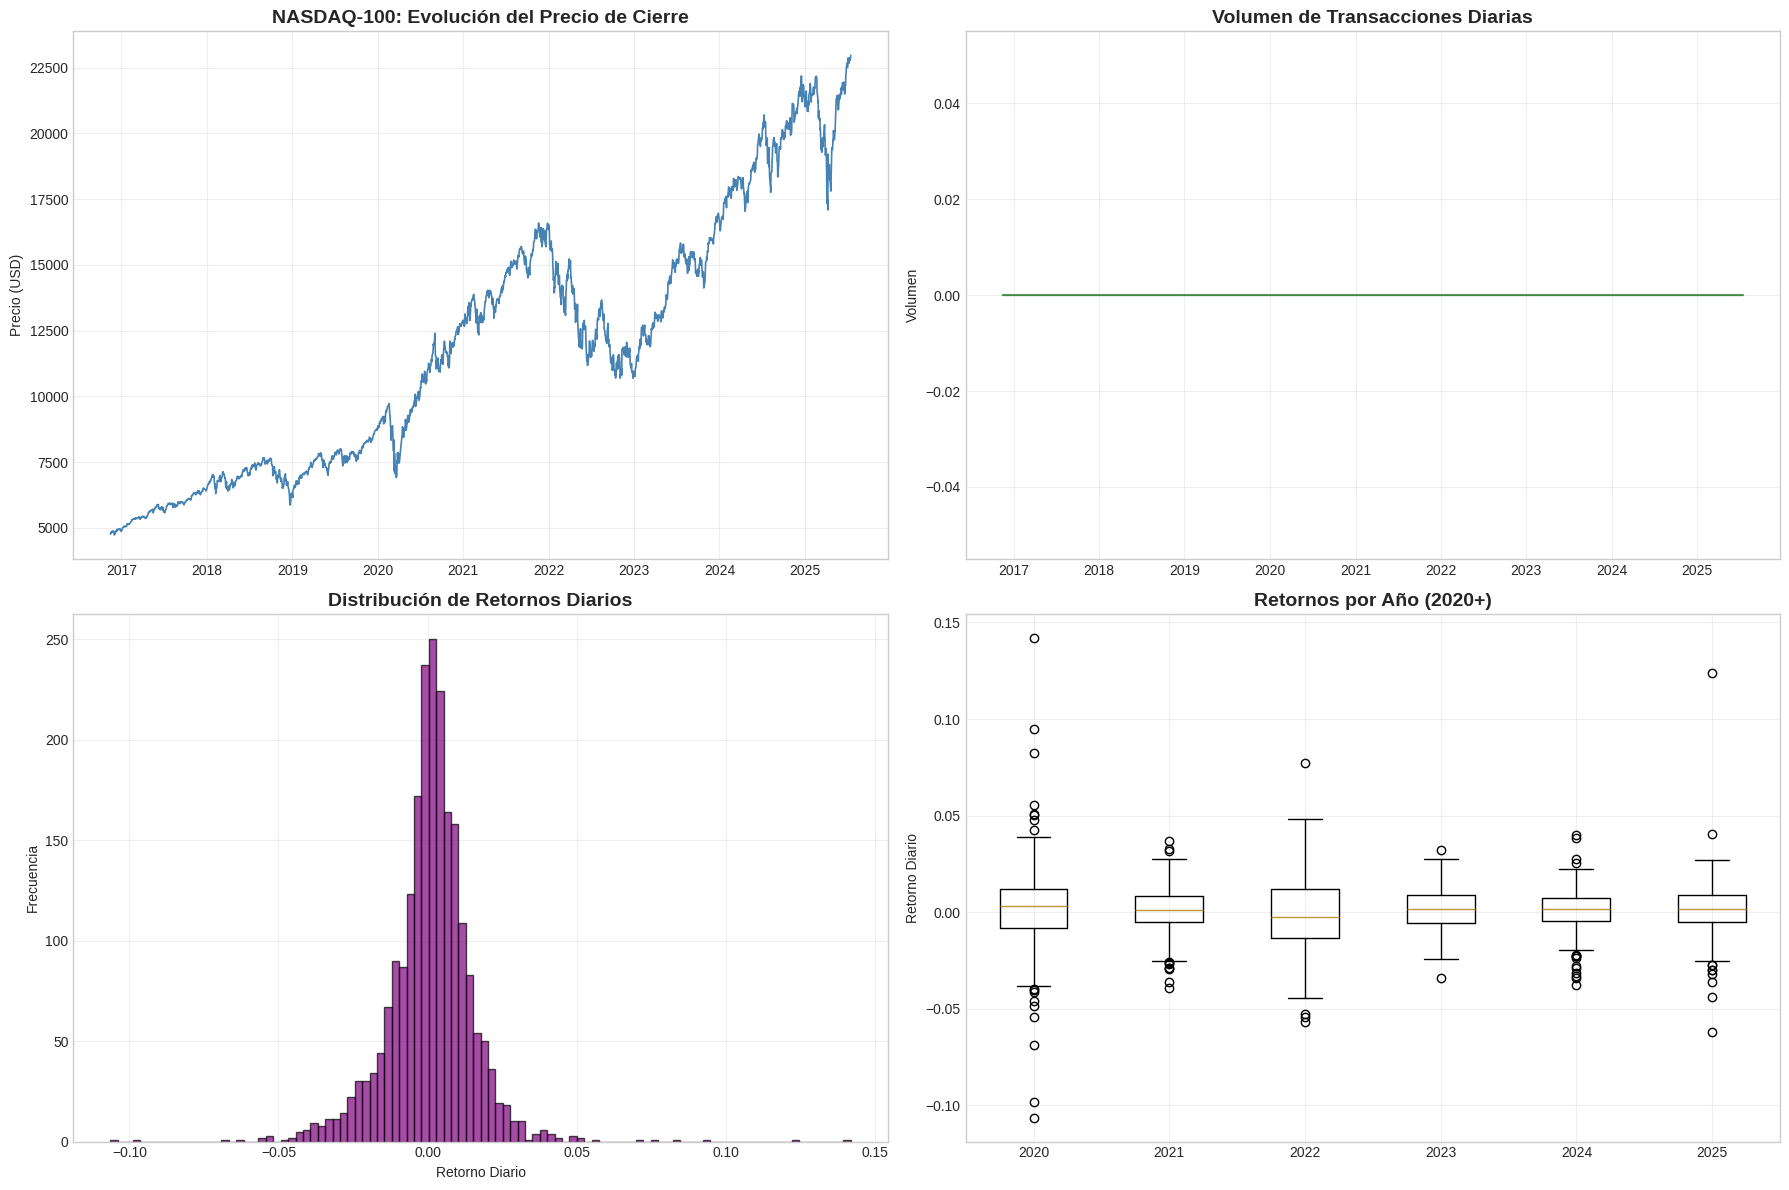


📈 MÉTRICAS CLAVE:
   • Volatilidad diaria: 0.0146 (1.46%)
   • Volatilidad anualizada: 0.2318 (23.18%)
   • Retorno diario promedio: 0.0008 (0.08%)
   • Rango de precios: $4737.10 - $22966.50


In [24]:
print("\n" + "="*50)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("="*50)

# --- VALIDACIÓN DE ENTRADA ---
# Revisar que DataFrame no esté vacío
if df_raw.empty:
    raise ValueError("El DataFrame 'df_raw' está vacío.")

# Revisar que existan las columnas necesarias
required_cols = ['Close', 'Volume']
for col in required_cols:
    if col not in df_raw.columns:
        raise ValueError(f"Falta la columna obligatoria: {col}")

# --- Gráfico principal del precio de cierre ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Precio de cierre histórico
axes[0,0].plot(df_raw.index, df_raw['Close'], color='steelblue', linewidth=1.2)
axes[0,0].set_title('NASDAQ-100: Evolución del Precio de Cierre', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Precio (USD)')
axes[0,0].grid(True, alpha=0.3)

# Volumen de transacciones
axes[0,1].plot(df_raw.index, df_raw['Volume'], color='darkgreen', alpha=0.7)
axes[0,1].set_title('Volumen de Transacciones Diarias', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Volumen')
axes[0,1].grid(True, alpha=0.3)

# Retornos diarios calculados DENTRO del DataFrame para evitar desalineación
df_temp = df_raw.copy()
df_temp['Daily_Return'] = df_temp['Close'].pct_change()
daily_returns = df_temp['Daily_Return'].dropna()

axes[1,0].hist(daily_returns, bins=100, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].set_title('Distribución de Retornos Diarios', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Retorno Diario')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].grid(True, alpha=0.3)

# Box plot anual (robustez frente a falta de datos)
df_temp['Year'] = df_temp.index.year
yearly_data = []
years = []
for year in sorted(df_temp['Year'].unique()):
    if year >= 2020:
        year_returns = df_temp[df_temp['Year'] == year]['Daily_Return'].dropna()
        if len(year_returns) > 50:
            yearly_data.append(year_returns.values)
            years.append(year)

if yearly_data and years:
    axes[1,1].boxplot(yearly_data, labels=years)
    axes[1,1].set_title('Retornos por Año (2020+)', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Retorno Diario')
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,1].set_axis_off()
    axes[1,1].text(0.5, 0.5, "No hay suficientes datos\npara mostrar boxplot anual",
                   ha='center', va='center', fontsize=12, color='gray', transform=axes[1,1].transAxes)

plt.tight_layout()
plt.show()

# --- Estadísticas clave ---

# Protege contra DataFrames muy pequeños
if len(daily_returns) == 0:
    print("No hay suficientes datos de retornos para mostrar estadísticas clave.")
else:
    volatility_daily = daily_returns.std()
    volatility_annual = volatility_daily * np.sqrt(252)
    print(f"\n📈 MÉTRICAS CLAVE:")
    print(f"   • Volatilidad diaria: {volatility_daily:.4f} ({volatility_daily*100:.2f}%)")
    print(f"   • Volatilidad anualizada: {volatility_annual:.4f} ({volatility_annual*100:.2f}%)")
    print(f"   • Retorno diario promedio: {daily_returns.mean():.4f} ({daily_returns.mean()*100:.2f}%)")
    print(f"   • Rango de precios: ${df_raw['Close'].min():.2f} - ${df_raw['Close'].max():.2f}")


In [26]:
target_col = 'Target'


In [47]:
# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constante global para la columna objetivo
TARGET_COL = 'Target'

def create_features(df: pd.DataFrame, target_col: str = TARGET_COL) -> pd.DataFrame:

    # Validar columnas necesarias
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Columna obligatoria '{col}' no encontrada en DataFrame.")

    # Validar índice datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("El índice del DataFrame debe ser de tipo DatetimeIndex.")

    df_feat = df.copy()

    # Medias móviles simples
    df_feat['SMA_20'] = df_feat['Close'].rolling(window=20).mean()
    df_feat['SMA_50'] = df_feat['Close'].rolling(window=50).mean()
    df_feat['SMA_200'] = df_feat['Close'].rolling(window=200).mean()

    # Retornos diarios y logarítmicos
    df_feat['Daily_Return'] = df_feat['Close'].pct_change()
    df_feat['Log_Return'] = np.log(df_feat['Close'] / df_feat['Close'].shift(1))

    # Volatilidad histórica (std dev) sobre ventanas
    df_feat['Vol_20d'] = df_feat['Daily_Return'].rolling(window=20).std()
    df_feat['Vol_50d'] = df_feat['Daily_Return'].rolling(window=50).std()

    # Cambio intradía y rango diario
    df_feat['Daily_Change'] = df_feat['Close'] - df_feat['Open']
    df_feat['High_Low_Range'] = df_feat['High'] - df_feat['Low']

    # Variables temporales calendario
    df_feat['Year'] = df_feat.index.year
    df_feat['Month'] = df_feat.index.month
    df_feat['DayOfWeek'] = df_feat.index.dayofweek
    df_feat['DayOfYear'] = df_feat.index.dayofyear
    df_feat['WeekOfYear'] = df_feat.index.isocalendar().week.astype(int)
    df_feat['Quarter'] = df_feat.index.quarter

    # RSI (Relative Strength Index), periodo 14 días
    delta = df_feat['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_feat['RSI_14'] = 100 - (100 / (1 + rs))

    # Definición variable objetivo: Cierre día siguiente
    df_feat[target_col] = df_feat['Close'].shift(-1)

    # Eliminar filas con NaN resultantes del cálculo de features
    df_clean = df_feat.dropna().copy()

    if df_clean.empty:
        raise ValueError("Después de crear características, el DataFrame está vacío. Verifique cantidad de datos.")

    logging.info(f"✅ Características creadas exitosamente: {df_clean.shape[0]:,} filas × {df_clean.shape[1]} columnas")

    return df_clean



df_features = create_features(df_raw)

print("\n--- Resumen de Features creadas ---")
print(f"Total filas: {df_features.shape[0]}")
print(f"Fechas: {df_features.index.min().date()} a {df_features.index.max().date()}")
print(f"Columnas (features + target): {list(df_features.columns)}")

# Mostrar primeras filas para inspección
print(df_features.head())



--- Resumen de Features creadas ---
Total filas: 2027
Fechas: 2017-08-24 a 2025-07-14
Columnas (features + target): ['Open', 'High', 'Low', 'Close', 'Volume', 'TickVolume', 'SMA_20', 'SMA_50', 'SMA_200', 'Daily_Return', 'Log_Return', 'Vol_20d', 'Vol_50d', 'Daily_Change', 'High_Low_Range', 'Year', 'Month', 'DayOfWeek', 'DayOfYear', 'WeekOfYear', 'Quarter', 'RSI_14', 'Target']
              Open    High     Low   Close  Volume  TickVolume    SMA_20  \
Date                                                                       
2017-08-24  5842.1  5873.9  5803.4  5845.5       0       51568  5876.970   
2017-08-25  5843.8  5874.2  5817.3  5824.6       0       50330  5872.420   
2017-08-28  5805.9  5855.6  5801.6  5845.6       0       42231  5870.355   
2017-08-29  5808.6  5874.9  5776.9  5868.7       0       62437  5867.115   
2017-08-30  5866.8  5943.3  5862.8  5934.3       0       30045  5867.920   

              SMA_50    SMA_200  Daily_Return  Log_Return  Vol_20d  Vol_50d  \
Date     

In [48]:
# 1. Definir constantes clave
RANDOM_STATE = 42
TARGET_COL = 'Target'

# 2. Verifica que df_features existe (debes ejecutar Bloque 6 antes)
if 'df_features' not in globals() or df_features.empty:
    raise ValueError("DataFrame 'df_features' no está definido o está vacío. Ejecuta el bloque de ingeniería de características primero.")

# 3. Definir columnas a excluir y features
exclude_cols = [TARGET_COL, 'Daily_Return', 'Log_Return', 'Close', 'Open', 'High', 'Low']
feature_columns = [col for col in df_features.columns if col not in exclude_cols]

if len(feature_columns) == 0:
    raise ValueError("No hay features seleccionadas para modelado.")

# 4. Separar X (características) e y (target)
X = df_features[feature_columns].copy()
y = df_features[TARGET_COL].copy()

# 5. Split principal: entrenamiento/prueba (80/20), sin shuffle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=False
)

# 6. Split extra para validación interna (early stopping): 80%/20% sobre entrenamiento
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, shuffle=False
)

# 7. Escalado StandardScaler
scaler = StandardScaler()
X_train_main_scaled = scaler.fit_transform(X_train_main)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 8. Convertir a DataFrame, nombres de columnas y mantener índices
X_train_main_scaled_df = pd.DataFrame(X_train_main_scaled, columns=feature_columns, index=X_train_main.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=feature_columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

# 9. Si quieres, imprime formas para confirmar:
print(f"X_train_main_scaled_df: {X_train_main_scaled_df.shape}")
print(f"X_val_scaled_df: {X_val_scaled_df.shape}")
print(f"X_test_scaled_df: {X_test_scaled_df.shape}")


X_train_main_scaled_df: (1296, 16)
X_val_scaled_df: (325, 16)
X_test_scaled_df: (406, 16)


In [41]:
required_vars = [
    "X_train_main_scaled_df", "y_train_main",
    "X_val_scaled_df", "y_val",
    "X_test_scaled_df", "y_test",
    "RANDOM_STATE"
]

missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    print(f"Faltan variables definidas: {missing_vars}")
else:
    print("Todas las variables necesarias están definidas y disponibles.")


Todas las variables necesarias están definidas y disponibles.


In [49]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("\n" + "=" * 50)
print("ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS")
print("=" * 50)

# Validar que las variables necesarias existan
required_vars = [
    "X_train_main_scaled_df", "y_train_main",
    "X_val_scaled_df", "y_val",
    "X_test_scaled_df", "y_test",
    "RANDOM_STATE"
]
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(f"No están definidas las variables necesarias: {missing_vars}. "
                    f"Ejecuta primero el bloque de preparación de datos.")

# PASO 1: Entrenamiento inicial con early stopping SI LA VERSIÓN LO PERMITE
try:
    model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=0.1,
        reg_alpha=0.5,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        eval_metric='rmse',
        early_stopping_rounds=50  # Solo se acepta si la versión lo permite
    )

    model.fit(
        X_train_main_scaled_df, y_train_main,
        eval_set=[(X_val_scaled_df, y_val)],
        verbose=50
    )
except TypeError:
    print("La versión actual de XGBoost no soporta 'early_stopping_rounds' en XGBRegressor. Se entrenará sin early stopping.")
    model = xgb.XGBRegressor(
        n_estimators=1000,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=0.1,
        reg_alpha=0.5,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        eval_metric='rmse'
    )
    model.fit(
        X_train_main_scaled_df, y_train_main,
        eval_set=[(X_val_scaled_df, y_val)],
        verbose=50
    )

print(f"✅ Mejor número de árboles (rondas): {getattr(model, 'best_iteration', 'No disponible')}")

# PASO 2: Evaluación inicial en test
y_pred_initial = model.predict(X_test_scaled_df)
initial_rmse = np.sqrt(mean_squared_error(y_test, y_pred_initial))
initial_mae = mean_absolute_error(y_test, y_pred_initial)
initial_r2 = r2_score(y_test, y_pred_initial)

print(f"\nRMSE inicial: {initial_rmse:.4f}")
print(f"MAE inicial: {initial_mae:.4f}")
print(f"R² inicial: {initial_r2:.4f}")

# PASO 3: Optimización con GridSearchCV (sin early stopping)
if hasattr(model, 'best_iteration') and model.best_iteration is not None:
    n_estimators_best = int(model.best_iteration)
    if n_estimators_best <= 0:
        n_estimators_best = 1000
else:
    n_estimators_best = 1000

param_grid = {
    'n_estimators': [n_estimators_best],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1]
}

xgb_grid_model = xgb.XGBRegressor(
    random_state=RANDOM_STATE,
    eval_metric='rmse',
    verbosity=0
)

grid_search = GridSearchCV(
    estimator=xgb_grid_model,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_main_scaled_df, y_train_main)

print(f"\n✅ Mejores parámetros tras GridSearchCV: {grid_search.best_params_}")
print(f"✅ Mejor R² validación cruzada: {grid_search.best_score_:.4f}")

# PASO 4: Evaluación final con mejor modelo
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test_scaled_df)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
final_mae = mean_absolute_error(y_test, y_pred_best)
final_r2 = r2_score(y_test, y_pred_best)

print(f"\nRMSE final: {final_rmse:.4f}")
print(f"MAE final: {final_mae:.4f}")
print(f"R² final: {final_r2:.4f}")

if final_r2 < 0.3:
    print("⚠️  R² bajo: revisa datos, ingeniería de variables y posibles outliers.")
else:
    print("✅ ¡Buen desempeño del modelo!")

# PASO 5: Guardar el mejor modelo
model_filename = 'best_xgbregressor_nasdaq100_model.joblib'
joblib.dump(best_model, model_filename)
print(f"\n✅ Modelo guardado como: {model_filename}")

# Mostrar tabla comparativa
results_comparison = pd.DataFrame({
    'Model': ['XGBoost Inicial', 'XGBoost Optimizado'],
    'Dataset': ['Test', 'Test'],
    'RMSE': [initial_rmse, final_rmse],
    'MAE': [initial_mae, final_mae],
    'R²': [initial_r2, final_r2]
})

print("\n📊 COMPARACIÓN DE RESULTADOS:")
display(results_comparison.round(4))

# Guardar modelo para uso futuro
trained_models = {'XGBoost_Optimizado': best_model}



ENTRENAMIENTO Y OPTIMIZACIÓN DE MODELOS
[0]	validation_0-rmse:3749.93577
[50]	validation_0-rmse:2292.48786
[100]	validation_0-rmse:1430.49492
[150]	validation_0-rmse:937.57189
[200]	validation_0-rmse:671.59267
[250]	validation_0-rmse:543.28223
[300]	validation_0-rmse:481.96230
[350]	validation_0-rmse:453.67432
[400]	validation_0-rmse:441.67692
[450]	validation_0-rmse:436.61131
[500]	validation_0-rmse:432.64358
[550]	validation_0-rmse:430.20512
[600]	validation_0-rmse:428.73226
[650]	validation_0-rmse:427.43575
[700]	validation_0-rmse:427.09254
[750]	validation_0-rmse:427.15838
[800]	validation_0-rmse:427.46728
[808]	validation_0-rmse:427.63168
✅ Mejor número de árboles (rondas): 759

RMSE inicial: 4377.7932
MAE inicial: 4050.0330
R² inicial: -6.3602
Fitting 3 folds for each of 64 candidates, totalling 192 fits

✅ Mejores parámetros tras GridSearchCV: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 759, 'reg_alpha': 0.5, 'reg_lambda': 1, 'su

,Model,Dataset,RMSE,MAE,R²
0,XGBoost Inicial,Test,4377.7932,4050.0330,-6.3602
1,XGBoost Optimizado,Test,4585.5509,4266.9967,-7.0754


from matplotlib import pyplot as plt
_df_0['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['R²'].plot(kind='hist', bins=20, title='R²')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='RMSE', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='MAE', y='R²', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['R²']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('R²')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE'}, axis=1)
              .sort_values('RMSE', ascending=True))
  xs = counted['RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['R²']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('R²')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE'}, axis=1)
              .sort_values('MAE', ascending=True))
  xs = counted['MAE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['R²'].plot(kind='line', figsize=(8, 4), title='R²')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='R²', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [52]:

rmse_baseline = np.sqrt(mean_squared_error(y_test, np.full_like(y_test, y_train_main.mean())))
r2_baseline = r2_score(y_test, np.full_like(y_test, y_train_main.mean()))
print(f"RMSE baseline (media): {rmse_baseline:.2f}  R²: {r2_baseline:.4f}")


RMSE baseline (media): 9692.76  R²: -35.0806


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


# Entrenadores a comparar
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBRegressor(
        n_estimators=best_model.n_estimators,  # usa el óptimo de tu tuning
        max_depth=best_model.max_depth,
        learning_rate=best_model.learning_rate,
        subsample=best_model.subsample,
        colsample_bytree=best_model.colsample_bytree,
        gamma=best_model.gamma,
        reg_alpha=best_model.reg_alpha,
        reg_lambda=best_model.reg_lambda,
        random_state=RANDOM_STATE,
        eval_metric='rmse'
    )
}

results = []
for name, model in models.items():
    model.fit(X_train_main_scaled_df, y_train_main)
    y_pred = model.predict(X_test_scaled_df)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })
    print(f"{name} - Test RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")

results_df = pd.DataFrame(results)
print("\n=== COMPARACIÓN DE MODELOS (Test Set) ===")
print(results_df.round(4))


LinearRegression - Test RMSE: 399.82, MAE: 291.14, R²: 0.9386
RandomForest - Test RMSE: 4555.32, MAE: 4255.86, R²: -6.9692
XGBoost - Test RMSE: 4585.55, MAE: 4267.00, R²: -7.0754

=== COMPARACIÓN DE MODELOS (Test Set) ===
              Model       RMSE        MAE      R²
0  LinearRegression   399.8229   291.1398  0.9386
1      RandomForest  4555.3213  4255.8620 -6.9692
2           XGBoost  4585.5509  4266.9967 -7.0754


In [55]:
from tensorflow import keras

mlp = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=[X_train_main_scaled_df.shape[1]]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

mlp.compile(loss='mse', optimizer='adam')

# Entrenamiento
mlp.fit(X_train_main_scaled_df, y_train_main, epochs=50, validation_data=(X_val_scaled_df, y_val), verbose=1)

y_pred_mlp = mlp.predict(X_test_scaled_df).flatten()
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP (Keras) - Test RMSE: {rmse_mlp:.2f}, MAE: {mae_mlp:.2f}, R²: {r2_mlp:.4f}")

# Añade al DataFrame:
results.append({
    'Model': 'MLP (Keras)', 'RMSE': rmse_mlp, 'MAE': mae_mlp, 'R²': r2_mlp
})
results_df = pd.DataFrame(results)
print("\n=== COMPARACIÓN DE MODELOS (Test Set) ===")
print(results_df.round(4))


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 115519240.0000 - val_loss: 184288976.0000
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 109473152.0000 - val_loss: 183927024.0000
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 114201112.0000 - val_loss: 182911200.0000
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 111429208.0000 - val_loss: 180692640.0000
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 107968072.0000 - val_loss: 176685296.0000
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 108867768.0000 - val_loss: 170566896.0000
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 104319144.0000 - val_loss: 161978672.0000
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101292928.0000 - val_loss: 150599712.0000
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 91098568.0000 - val_loss: 136716224.0000
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85673768.0000 - val_loss: 120669688.0000
E

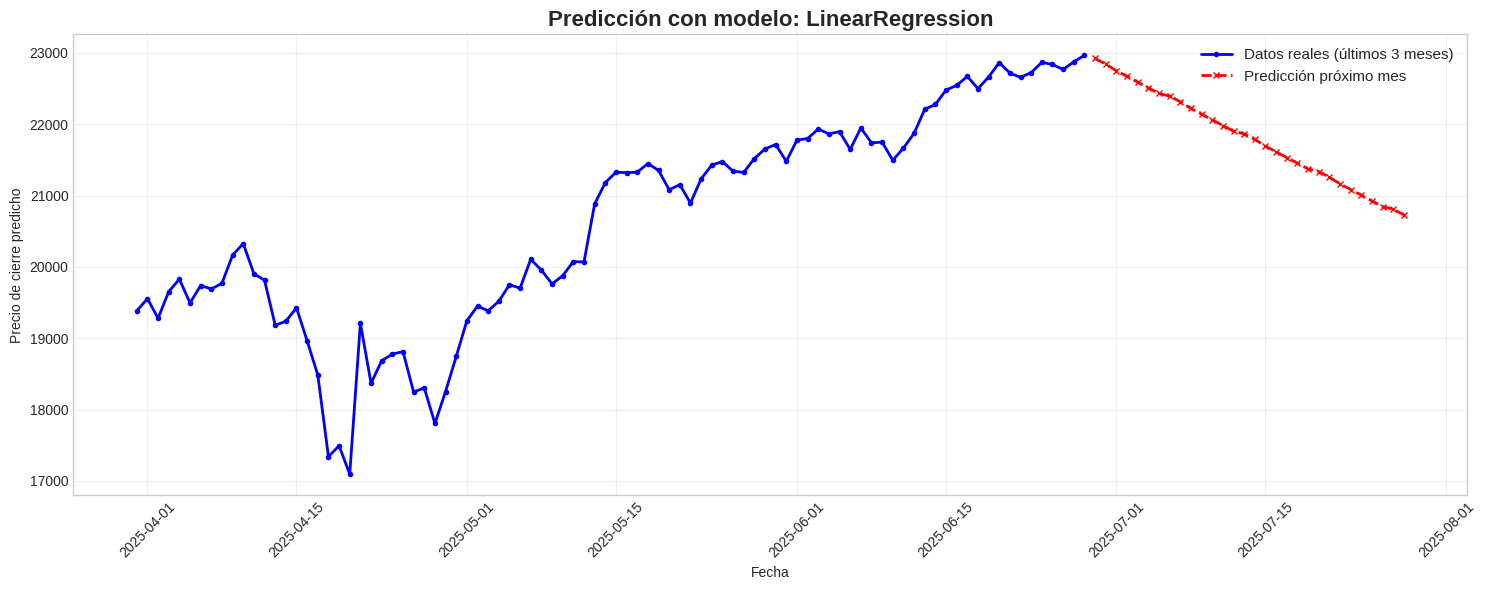

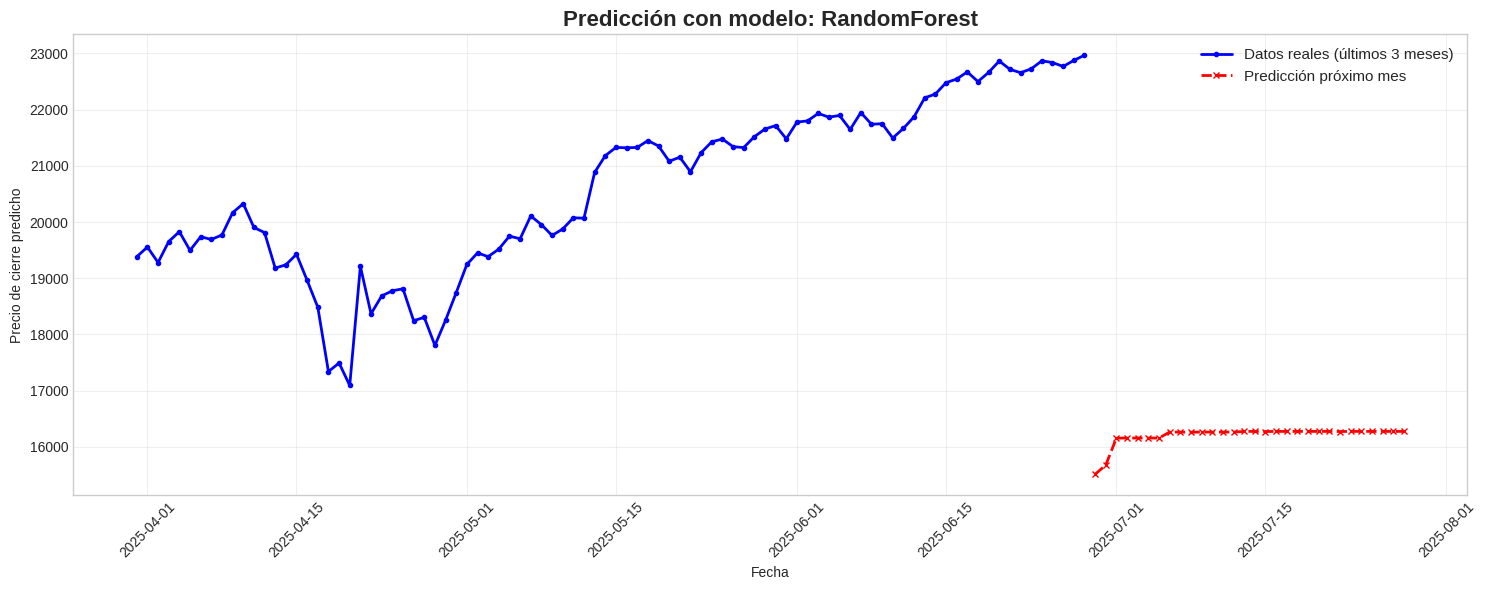

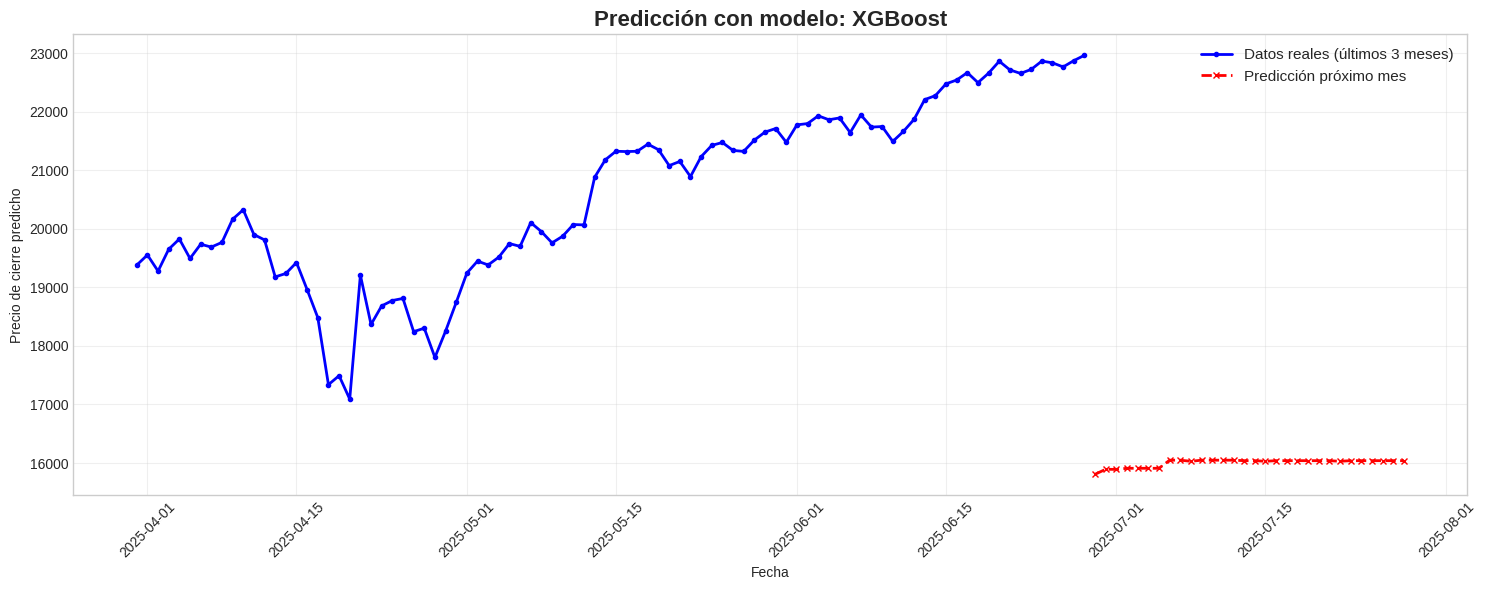


=== COMPARATIVA FINAL DE MODELOS ===
              Model  RMSE test   MAE test  R2 test  1-step futuro error
0  LinearRegression   399.8229   291.1398   0.9386              43.6976
1      RandomForest  4555.3213  4255.8620  -6.9692            7454.4970
2           XGBoost  4585.5509  4266.9967  -7.0754            7158.8857

El modelo con menor RMSE en test y menor error en la predicción del siguiente día es el más preciso para tus características actuales.


In [56]:
#Generar predicciones futuras (próximo mes)
num_future_days = 30
future_preds = {}
# Usar la última entrada conocida y replicarla 30 veces, ajustando campos temporales si corresponde
last_features = X_test_scaled_df.iloc[-1:].copy()
X_future_list = []
for i in range(num_future_days):
    future_x = last_features.copy()
    if 'DayOfYear' in future_x.columns:
        future_x['DayOfYear'] = (future_x['DayOfYear'].iloc[0] + i) % 365
    if 'DayOfWeek' in future_x.columns:
        future_x['DayOfWeek'] = (future_x['DayOfWeek'].iloc[0] + i) % 7
    if 'WeekOfYear' in future_x.columns:
        future_x['WeekOfYear'] = (future_x['WeekOfYear'].iloc[0] + i // 7) % 52
    X_future_list.append(future_x)
X_future = pd.concat(X_future_list, ignore_index=True)

for name, model in models.items():
    if name == 'MLP (Keras)':
        pred_future = model.predict(X_future).flatten()
    else:
        pred_future = model.predict(X_future)
    future_preds[name] = pred_future

# 3. Graficar últimos 3 meses y próximos 30 días por modelo
days_real = min(90, len(y_test))
last_n_days_real = y_test.iloc[-days_real:].values
last_date = pd.to_datetime('today') - pd.Timedelta(days=num_future_days)
start_date_real = last_date - pd.Timedelta(days=days_real-1)
dates_real = pd.date_range(start=start_date_real, end=last_date)
dates_future = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_future_days)

for name in models.keys():
    plt.figure(figsize=(15,6))
    plt.plot(dates_real, last_n_days_real, color='blue', lw=2, marker='o', markersize=3, label='Datos reales (últimos 3 meses)')
    plt.plot(dates_future, future_preds[name], color='red', lw=2, marker='x', markersize=4, linestyle='--', label='Predicción próximo mes')
    plt.title(f'Predicción con modelo: {name}', fontsize=16, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Precio de cierre predicho')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Métricas en TEST y pronóstico
results = []
for name, model in models.items():
    if name == 'MLP (Keras)':
        y_pred = model.predict(X_test_scaled_df).flatten()
    else:
        y_pred = model.predict(X_test_scaled_df)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Error sólo para la primera predicción futura vs último real
    error_one_ahead = abs(future_preds[name][0] - last_n_days_real[-1])
    results.append({
        'Model': name,
        'RMSE test': rmse,
        'MAE test': mae,
        'R2 test': r2,
        '1-step futuro error': error_one_ahead
    })

results_df = pd.DataFrame(results)
print("\n=== COMPARATIVA FINAL DE MODELOS ===")
print(results_df.round(4))
print("\nEl modelo con menor RMSE en test y menor error en la predicción del siguiente día es el más preciso para tus características actuales.")